# Pre-Requisite Installations

Please do the following steps initially:
- Install the AWS CLI from: https://aws.amazon.com/cli/
- Open a command line and type `aws configure`
- Leave the default region blank, and enter your AWS access id and secret key when prompted.

**(NOTE: Requires python >= 3.8)**

Dependencies (run the command in the next cell if you need these dependencies installed):
- boto3
- tqdm
- moviepy

In [1]:
# # Run these commands to install dependencies
# %pip install boto3
# %pip install tqdm
# %pip install moviepy
# %pip install wget (not needed)

# Import everything that is needed

In [2]:
# General imports
import os
from tqdm import tqdm
import json
import shutil
import random
import regex as re
import warnings
import uuid

# Video clipping
import datetime
from moviepy.editor import *
import subprocess

import tensorflow as tf

# Setup of ego4d downloads
from zipfile import ZipFile
from sys import platform
import requests
from io import BytesIO

# Custom classes
from utils import cd

# Print num of GPUs if available to use
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Download and Prepare Dataset

In [3]:
# Data paths that are defined
data_dir = 'data'
ego4d_setup_dir = 'ego4d_setup'
video_path = os.path.join(data_dir, 'videos')
annotation_path = os.path.join(data_dir, 'annotations')

def perform_setup(delete_annotations=False, delete_clips=False, delete_setup=False, delete_data=False):
    # If you want to delete already existing folders and contents
    if delete_setup and os.path.exists(ego4d_setup_dir): shutil.rmtree(ego4d_setup_dir)
    if delete_clips and os.path.exists(video_path): shutil.rmtree(video_path)
    if delete_annotations and os.path.exists(annotation_path): shutil.rmtree(annotation_path)
    if delete_data and os.path.exists(data_dir): shutil.rmtree(data_dir)

    # If any dir doesn't exist, make it
    if not os.path.exists(ego4d_setup_dir): os.makedirs(ego4d_setup_dir)
    if not os.path.exists(annotation_path): os.makedirs(annotation_path)
    if not os.path.exists(video_path): os.makedirs(video_path)

# Uncomment to setup the dataset
# delete_annotations: resets data/annotations 
# delete_clips: resets data/videos
# delete_setup: resets ego4d_setup directory (should be deleted normally anyway)
# delete_data: deletes all of data directory and its subdirectories
perform_setup()

> Retrieve ego4d data retrieval tool

In [5]:
# Retrieve the zip file for setup
print('Downloading the setup zip file..')

#Defining the zip file URL
url = 'https://github.com/facebookresearch/Ego4d/archive/refs/heads/main.zip'
# Split URL to get the file name
filename = url.split('/')[-1]

# Downloading the file by sending the request to the URL
req = requests.get(url)

# extracting the zip file contents
zipfile= ZipFile(BytesIO(req.content))
zipfile.extractall(ego4d_setup_dir)
print('Finished retrieving the setup files.')

Finished retrieving the setup files.


In [6]:
# Setting up the annotations and retrieving it
def setup_annotations(annotation_regex):
    # Check if annotations are already present
    if os.path.exists(annotation_path):
        files = next(os.walk(annotation_path), (None, None, []))[2]
        rgx = re.compile(annotation_regex)
        newlist = list(filter(rgx.match, files))

        # If not present, then download the annotations and save them
        if not newlist:
            print('Downloading annotations..')

            # Command to download ALL annotations
            command = ['python', '-m', 'ego4d.cli.cli', '--output_directory=ego4d_data', '--datasets', 'annotations', '--yes']
            with cd(os.path.join(ego4d_setup_dir, "Ego4d-main")):
                subprocess.run(command, check=True)
            # Copy and save only needed annotations in the data directory
            annotation_dir = os.path.join(ego4d_setup_dir, "Ego4d-main", "ego4d_data", "v1", "annotations")
            for file in os.listdir(annotation_dir):
                if "moments" in file: # TODO: Should be changed later to not have string
                    shutil.copy(os.path.join(annotation_dir, file), os.path.join(annotation_path))
            print('Finished downloading and setting up annotations.')
        else:
            print('Annotations already present!')
        
# Setting up the annotations
# annnotation_regex: regular expression of the files you want to copy from ALL annotations
setup_annotations("moments*")

Datasets to download: {'annotations'}
Download Path: ego4d_data/v1
Ego4D Metadata: ego4d_data/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'annotations' at: ego4d_data/v1/annotations
Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 31/31 [00:01<00:00, 19.18file/s]
  0%|          | 0.00/0.02M [00:00<?, ?b/s]

No existing videos to filter.


100%|█████████▉| 0.02M/0.02M [01:01<00:00, 29.3Mb/s]  

Checking file integrity...
Finished downloading and setting up annotations.


100%|██████████| 0.02M/0.02M [01:01<00:00, 349Mb/s] 


# Pre-Process

### Process moments_train.json
> Process moments_train.json and filter videos with given classes.

In [7]:
# The classes to be used in this project
classes = ["wash_dishes_/_utensils_/_bakeware_etc.", "use_phone", "browse_through_clothing_items_on_rack_/_shelf_/_hanger"]
# Training annotation file
training_file_name = "moments_train.json"
# Filtered clip uids dictionary containing only classes listed above
filtered_dict = {}

with open(os.path.join(annotation_path, training_file_name), 'r') as json_file:
    # Load the annotation file
    loaded_json = json.load(json_file)

    # For each video and for each clips within the video
    # retrieve clip_uid, video_uids, label, start_time, and end_time
    for video in loaded_json['videos']:
        for clip in video['clips']:
            filtered_dict[clip["clip_uid"]] = {
                "video_uid": video["video_uid"],
                "annotations": {}
            }
            annotation = clip["annotations"][0]
            for label_item in annotation["labels"]:
                label = label_item["label"]
                if label in classes and (label_item["end_time"] - label_item["start_time"] >= 5):
                    if label in filtered_dict[clip["clip_uid"]]["annotations"]:
                        filtered_dict[clip["clip_uid"]]["annotations"][label].append({
                            "start_time": label_item["start_time"],
                            "end_time": label_item["end_time"]
                        })
                    else:
                        filtered_dict[clip["clip_uid"]]["annotations"][label] = [{
                            "start_time": label_item["start_time"],
                            "end_time": label_item["end_time"]
                        }]
            # Filter to make sure no clips with empty annotations are taken
            if not filtered_dict[clip["clip_uid"]]["annotations"]:
                del filtered_dict[clip["clip_uid"]]

In [8]:
# print(len(filtered_dict))
# with open('test.json', 'w') as jp:
#     json.dump(filtered_dict, jp, indent=4)

### Trim videos into clips
> Using moviepy, split videos into clips

In [12]:
# Function to cut/trim the video to desired lengths and save it
def cut_video(video_path, times, save_path):
    # Load the video once and close using context manager
    with VideoFileClip(video_path) as vid_clip:
        for segment in times:
            # Segment information and random filename generation
            start_time = segment['start_time']
            end_time = segment['end_time']
            fileName = f"{uuid.uuid1()}.mp4"

            # Convert the amount of seconds in time xx:xx:xx.xxxxxx
            start_time = str(datetime.timedelta(seconds = start_time))
            end_time = str(datetime.timedelta(seconds = end_time))

            # Clip the video and save it to the specified path
            clip = vid_clip.subclip(start_time, end_time)
            if not os.path.exists(save_path): os.makedirs(save_path)
            clip.write_videofile(os.path.join(save_path, fileName))

In [13]:
%%capture cap --no-stderr
# ^ To save the output to external file because it's waaaaay too large to display in notebook
# Function to retrieve a sample of clips for each class
def generate_clip_uids(filtered_annotations, num_clips):
    # Seperate clip uids by their class
    all_clips_dict = {}
    for clip_uid, clip_info in tqdm(filtered_annotations.items()):
        for annotation in clip_info["annotations"]:
            if annotation in all_clips_dict:
                all_clips_dict[annotation].append(clip_uid)
            else:
                all_clips_dict[annotation] = [clip_uid]
    # Grab random sample of num_clips for each class
    for cls in all_clips_dict:
        all_clips_dict[cls] = random.sample(all_clips_dict[cls], 15)
    return all_clips_dict


# Function to download and setup the clips 
def setup_clips(filtered_annotations, save_path, overwrite=False, num_clips=15):
    # Check if the clips already exist if we are not overwriting
    if not overwrite:
        dirs = next(os.walk(video_path), (None, None, []))[1]
        for dir in dirs:
            files = next(os.walk(os.path.join(video_path, dir)), (None, None, []))[2]
            if dir.replace(";", "/") in all_clips_dict and files:
                warnings.warn("Clips may already exist. If you want to redo the process, set the `overwrite` argument to true while calling the function.")
                return
    # Get all the randomly generated clip samples and go through them
    all_clips_dict = generate_clip_uids(filtered_annotations, num_clips)
    for cls, clip_uids in all_clips_dict.items():
        useable_name = cls.replace("/", ";") # Paths can't have / in their name so, replace it

        # Make sure the required path exists without old items
        if os.path.exists(os.path.join(video_path, useable_name)): shutil.rmtree(os.path.join(video_path, useable_name))
        os.makedirs(os.path.join(video_path, useable_name))

        print(f"Processing clip for class: {cls}")
        for clip_uid in tqdm(clip_uids):
            # Command to retrieve clip by its uid
            command = ['python', '-m', 'ego4d.cli.cli', '--output_directory=temp_clip', 
            '--datasets', 'clips', '--video_uids', clip_uid, '--yes']
            # Path to the downloaded clip
            full_vid_path = os.path.join(ego4d_setup_dir, "Ego4d-main", "temp_clip", "v1", "clips")
            
            # Use context manager to ensure any change in directory is returned to original
            with cd(os.path.join(ego4d_setup_dir, "Ego4d-main")):
                # Download the video
                subprocess.run(command, check=True)
                
            # Get the clip information and trim the video
            clip_info = filtered_annotations[clip_uid]
            for label in clip_info['annotations']:
                folder_label = label.replace("/", ";")
                cut_video(os.path.join(full_vid_path, f"{clip_uid}.mp4"), clip_info['annotations'][label], os.path.join(video_path, folder_label))
            
            # Clean up after for the specific clip
            shutil.rmtree(os.path.join(ego4d_setup_dir, "Ego4d-main", "temp_clip"))
    
    # Clean up the overall setup directory
    shutil.rmtree(ego4d_setup_dir)

# Download and setup clips
# filtered_dict: previously filtered dictionary of clips
# video_path: path to save the clips
setup_clips(filtered_dict, video_path)


100%|██████████| 355/355 [00:00<00:00, 289346.66it/s]


Processing clip for class: browse_through_clothing_items_on_rack_/_shelf_/_hanger


  0%|          | 0/15 [00:00<?, ?it/s]

Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:00<00:00,  6.13file/s]
  0%|          | 0.00/719k [00:00<?, ?b/s]

No existing videos to filter.


100%|██████████| 719k/719k [00:17<00:00, 40.5Mb/s] 


Checking file integrity...


                                      
                                                               

  0%|          | 0/15 [00:36<?, ?it/s]               
                                      
                                                               

  0%|          | 0/15 [00:36<?, ?it/s]                          


Moviepy - Building video data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/99b0cc06-43f1-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in 99b0cc06-43f1-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3






                                      
                                                               

  0%|          | 0/15 [00:36<?, ?it/s]                          
                                      
                                                               

  0%|          | 0/15 [00:36<?, ?it/s]                          


MoviePy - Done.
Moviepy - Writing video data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/99b0cc06-43f1-11ed-8d87-1249c3cc3fc4.mp4







































                                      
                                                               

  0%|          | 0/15 [00:39<?, ?it/s]                          
                                      
                                                               

  7%|▋         | 1/15 [00:39<09:16, 39.78s/it]

Moviepy - Done !
Moviepy - video ready data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/99b0cc06-43f1-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:00<00:00,  5.91file/s]
  0%|          | 0.00/748k [00:00<?, ?b/s]

No existing videos to filter.


100%|██████████| 748k/748k [00:15<00:00, 48.7Mb/s] 


Checking file integrity...


                                              
                                                               

  7%|▋         | 1/15 [01:12<09:16, 39.78s/it]                  
                                              
                                                               

  7%|▋         | 1/15 [01:12<09:16, 39.78s/it]                  


Moviepy - Building video data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/af3f0452-43f1-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in af3f0452-43f1-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3










                                              
                                                               

  7%|▋         | 1/15 [01:13<09:16, 39.78s/it]                  
                                              
                                                               

  7%|▋         | 1/15 [01:13<09:16, 39.78s/it]                  


MoviePy - Done.
Moviepy - Writing video data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/af3f0452-43f1-11ed-8d87-1249c3cc3fc4.mp4















































































































































                                              
                                                               

  7%|▋         | 1/15 [01:22<09:16, 39.78s/it]                  
                                              
                                                               

 13%|█▎        | 2/15 [01:22<08:58, 41.46s/it]

Moviepy - Done !
Moviepy - video ready data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/af3f0452-43f1-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:00<00:00,  6.08file/s]
  0%|          | 0.00/661k [00:00<?, ?b/s]

No existing videos to filter.


100%|██████████| 661k/661k [00:13<00:00, 48.2Mb/s] 


Checking file integrity...


                                              
                                                               

 13%|█▎        | 2/15 [01:46<08:58, 41.46s/it]                  
                                              
                                                               

 13%|█▎        | 2/15 [01:46<08:58, 41.46s/it]                  


Moviepy - Building video data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/c36fc1a0-43f1-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in c36fc1a0-43f1-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3








                                              
                                                               

 13%|█▎        | 2/15 [01:47<08:58, 41.46s/it]                  
                                              
                                                               

 13%|█▎        | 2/15 [01:47<08:58, 41.46s/it]                  


MoviePy - Done.
Moviepy - Writing video data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/c36fc1a0-43f1-11ed-8d87-1249c3cc3fc4.mp4



































































                                              
                                                               

 13%|█▎        | 2/15 [01:51<08:58, 41.46s/it]                  
                                              
                                                               

 20%|██        | 3/15 [01:51<07:11, 35.96s/it]

Moviepy - Done !
Moviepy - video ready data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/c36fc1a0-43f1-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:00<00:00,  5.90file/s]
  0%|          | 0.00/674k [00:00<?, ?b/s]

No existing videos to filter.


100%|██████████| 674k/674k [00:15<00:00, 44.0Mb/s] 


Checking file integrity...


                                              
                                                               

 20%|██        | 3/15 [02:22<07:11, 35.96s/it]                  
                                              
                                                               

 20%|██        | 3/15 [02:22<07:11, 35.96s/it]                   


Moviepy - Building video data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/d88af7d0-43f1-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in d88af7d0-43f1-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3






                                              
                                                               

 20%|██        | 3/15 [02:22<07:11, 35.96s/it]                   
                                              
                                                               

 20%|██        | 3/15 [02:22<07:11, 35.96s/it]                   


MoviePy - Done.
Moviepy - Writing video data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/d88af7d0-43f1-11ed-8d87-1249c3cc3fc4.mp4







































































                                              
                                                               

 20%|██        | 3/15 [02:27<07:11, 35.96s/it]                   
                                              
                                                               

 27%|██▋       | 4/15 [02:27<06:32, 35.70s/it]

Moviepy - Done !
Moviepy - video ready data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/d88af7d0-43f1-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:00<00:00,  6.12file/s]
  0%|          | 0.00/727k [00:00<?, ?b/s]

No existing videos to filter.


100%|█████████▉| 725k/727k [00:16<00:00, 18.1Mb/s] 

Checking file integrity...


100%|██████████| 727k/727k [00:16<00:00, 43.4Mb/s]
                                              
                                                               

 27%|██▋       | 4/15 [02:52<06:32, 35.70s/it]                   
                                              
                                                               

 27%|██▋       | 4/15 [02:52<06:32, 35.70s/it]                   


Moviepy - Building video data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/ea5dd9b4-43f1-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in ea5dd9b4-43f1-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3








                                              
                                                               

 27%|██▋       | 4/15 [02:52<06:32, 35.70s/it]                   
                                              
                                                               

 27%|██▋       | 4/15 [02:52<06:32, 35.70s/it]                   


MoviePy - Done.
Moviepy - Writing video data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/ea5dd9b4-43f1-11ed-8d87-1249c3cc3fc4.mp4























































































                                              
                                                               

 27%|██▋       | 4/15 [02:58<06:32, 35.70s/it]                   
                                              
                                                               

 33%|███▎      | 5/15 [02:58<05:39, 33.97s/it]

Moviepy - Done !
Moviepy - video ready data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/ea5dd9b4-43f1-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:00<00:00,  6.09file/s]
  0%|          | 0.00/772k [00:00<?, ?b/s]

No existing videos to filter.


100%|██████████| 772k/772k [00:16<00:00, 46.1Mb/s] 


Checking file integrity...


                                              
                                                               

 33%|███▎      | 5/15 [03:23<05:39, 33.97s/it]                   
                                              
                                                               

 33%|███▎      | 5/15 [03:23<05:39, 33.97s/it]                   


Moviepy - Building video data/videos/use_phone/fcbeadc2-43f1-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in fcbeadc2-43f1-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3








                                              
                                                               

 33%|███▎      | 5/15 [03:23<05:39, 33.97s/it]                   
                                              
                                                               

 33%|███▎      | 5/15 [03:23<05:39, 33.97s/it]                   


MoviePy - Done.
Moviepy - Writing video data/videos/use_phone/fcbeadc2-43f1-11ed-8d87-1249c3cc3fc4.mp4



























































                                              
                                                               

 33%|███▎      | 5/15 [03:27<05:39, 33.97s/it]                   
                                              
                                                               

 33%|███▎      | 5/15 [03:27<05:39, 33.97s/it]                   


Moviepy - Done !
Moviepy - video ready data/videos/use_phone/fcbeadc2-43f1-11ed-8d87-1249c3cc3fc4.mp4


                                              
                                                               

 33%|███▎      | 5/15 [03:27<05:39, 33.97s/it]                   
                                              
                                                               

 33%|███▎      | 5/15 [03:27<05:39, 33.97s/it]                   


Moviepy - Building video data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/ff793226-43f1-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in ff793226-43f1-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3








                                              
                                                               

 33%|███▎      | 5/15 [03:27<05:39, 33.97s/it]                   
                                              
                                                               

 33%|███▎      | 5/15 [03:27<05:39, 33.97s/it]                   


MoviePy - Done.
Moviepy - Writing video data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/ff793226-43f1-11ed-8d87-1249c3cc3fc4.mp4















































































                                              
                                                               

 33%|███▎      | 5/15 [03:33<05:39, 33.97s/it]                   
                                              
                                                               

 40%|████      | 6/15 [03:33<05:09, 34.38s/it]

Moviepy - Done !
Moviepy - video ready data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/ff793226-43f1-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:02<00:00,  2.12s/file]
  0%|          | 0.00/604k [00:00<?, ?b/s]

No existing videos to filter.


100%|██████████| 604k/604k [00:14<00:00, 42.0Mb/s] 


Checking file integrity...


                                              
                                                               

 40%|████      | 6/15 [04:07<05:09, 34.38s/it]                    
                                              
                                                               

 40%|████      | 6/15 [04:07<05:09, 34.38s/it]                    


Moviepy - Building video data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/171b05f8-43f2-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in 171b05f8-43f2-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3














































                                              
                                                               

 40%|████      | 6/15 [04:09<05:09, 34.38s/it]                    
                                              
                                                               

 40%|████      | 6/15 [04:09<05:09, 34.38s/it]                    


MoviePy - Done.
Moviepy - Writing video data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/171b05f8-43f2-11ed-8d87-1249c3cc3fc4.mp4



Moviepy - Done !
Moviepy - video ready data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/171b05f8-43f2-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:00<00:00,  6.10file/s]
  0%|          | 0.00/716k [00:00<?, ?b/s]

No existing videos to filter.


100%|██████████| 716k/716k [00:15<00:00, 47.1Mb/s] 


Checking file integrity...


                                              
                                                               

 47%|████▋     | 7/15 [06:54<10:26, 78.27s/it]                    
                                              
                                                               

 47%|████▋     | 7/15 [06:54<10:26, 78.27s/it]                    


Moviepy - Building video data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/7ae40ae4-43f2-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in 7ae40ae4-43f2-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3










































                                              
                                                               

 47%|████▋     | 7/15 [06:56<10:26, 78.27s/it]                    
                                              
                                                               

 47%|████▋     | 7/15 [06:56<10:26, 78.27s/it]                    


MoviePy - Done.
Moviepy - Writing video data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/7ae40ae4-43f2-11ed-8d87-1249c3cc3fc4.mp4



Moviepy - Done !
Moviepy - video ready data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/7ae40ae4-43f2-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:00<00:00,  5.97file/s]
  0%|          | 0.00/550k [00:00<?, ?b/s]

No existing videos to filter.


100%|██████████| 550k/550k [00:06<00:00, 84.7Mb/s] 


Checking file integrity...


                                              
                                                                

 53%|█████▎    | 8/15 [09:13<11:38, 99.83s/it]                    
                                              
                                                                

 53%|█████▎    | 8/15 [09:13<11:38, 99.83s/it]                    


Moviepy - Building video data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/cd7abf8c-43f2-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in cd7abf8c-43f2-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3










                                              
                                                                

 53%|█████▎    | 8/15 [09:13<11:38, 99.83s/it]                    
                                              
                                                                

 53%|█████▎    | 8/15 [09:13<11:38, 99.83s/it]                    


MoviePy - Done.
Moviepy - Writing video data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/cd7abf8c-43f2-11ed-8d87-1249c3cc3fc4.mp4































































































                                              
                                                                

 53%|█████▎    | 8/15 [09:19<11:38, 99.83s/it]                    
                                              
                                                                

 60%|██████    | 9/15 [09:19<07:50, 78.42s/it]

Moviepy - Done !
Moviepy - video ready data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/cd7abf8c-43f2-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:00<00:00,  6.14file/s]
  0%|          | 0.00/639k [00:00<?, ?b/s]

No existing videos to filter.


100%|██████████| 639k/639k [00:15<00:00, 41.4Mb/s] 


Checking file integrity...


                                              
                                                                

 60%|██████    | 9/15 [09:52<07:50, 78.42s/it]                    
                                              
                                                                

 60%|██████    | 9/15 [09:52<07:50, 78.42s/it]                    


Moviepy - Building video data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/e4da4d46-43f2-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in e4da4d46-43f2-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3








                                              
                                                                

 60%|██████    | 9/15 [09:52<07:50, 78.42s/it]                    
                                              
                                                                

 60%|██████    | 9/15 [09:52<07:50, 78.42s/it]                    


MoviePy - Done.
Moviepy - Writing video data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/e4da4d46-43f2-11ed-8d87-1249c3cc3fc4.mp4

















































































                                              
                                                                

 60%|██████    | 9/15 [09:58<07:50, 78.42s/it]                    
                                              
                                                                

 67%|██████▋   | 10/15 [09:58<05:31, 66.29s/it]

Moviepy - Done !
Moviepy - video ready data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/e4da4d46-43f2-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:00<00:00,  6.02file/s]
  0%|          | 0.00/542k [00:00<?, ?b/s]

No existing videos to filter.


100%|██████████| 542k/542k [00:15<00:00, 35.9Mb/s] 


Checking file integrity...


                                               
                                                                

 67%|██████▋   | 10/15 [10:22<05:31, 66.29s/it]                   
                                               
                                                                

 67%|██████▋   | 10/15 [10:22<05:31, 66.29s/it]                   


Moviepy - Building video data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/f6a72666-43f2-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in f6a72666-43f2-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3










                                               
                                                                

 67%|██████▋   | 10/15 [10:22<05:31, 66.29s/it]                   
                                               
                                                                

 67%|██████▋   | 10/15 [10:22<05:31, 66.29s/it]                   


MoviePy - Done.
Moviepy - Writing video data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/f6a72666-43f2-11ed-8d87-1249c3cc3fc4.mp4















































































































                                               
                                                                

 67%|██████▋   | 10/15 [10:29<05:31, 66.29s/it]                   
                                               
                                                                

 73%|███████▎  | 11/15 [10:29<03:41, 55.43s/it]

Moviepy - Done !
Moviepy - video ready data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/f6a72666-43f2-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:00<00:00,  5.96file/s]
  0%|          | 0.00/607k [00:00<?, ?b/s]

No existing videos to filter.


 99%|█████████▊| 599k/607k [00:13<00:00, 18.2Mb/s] 

Checking file integrity...


100%|██████████| 607k/607k [00:14<00:00, 42.5Mb/s]
                                               
                                                                

 73%|███████▎  | 11/15 [10:59<03:41, 55.43s/it]                   
                                               
                                                                

 73%|███████▎  | 11/15 [10:59<03:41, 55.43s/it]                   


Moviepy - Building video data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/0d1fa062-43f3-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in 0d1fa062-43f3-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3












                                               
                                                                

 73%|███████▎  | 11/15 [11:00<03:41, 55.43s/it]                   
                                               
                                                                

 73%|███████▎  | 11/15 [11:00<03:41, 55.43s/it]                   


MoviePy - Done.
Moviepy - Writing video data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/0d1fa062-43f3-11ed-8d87-1249c3cc3fc4.mp4











































































































































































































































                                               
                                                                

 73%|███████▎  | 11/15 [11:14<03:41, 55.43s/it]                   
                                               
                                                                

 80%|████████  | 12/15 [11:14<02:37, 52.49s/it]

Moviepy - Done !
Moviepy - video ready data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/0d1fa062-43f3-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:00<00:00,  5.47file/s]
  0%|          | 0.00/623k [00:00<?, ?b/s]

No existing videos to filter.


 98%|█████████▊| 612k/623k [00:08<00:00, 50.0Mb/s] 

Checking file integrity...


100%|██████████| 623k/623k [00:09<00:00, 67.0Mb/s]
                                               
                                                                

 80%|████████  | 12/15 [11:42<02:37, 52.49s/it]                   
                                               
                                                                

 80%|████████  | 12/15 [11:42<02:37, 52.49s/it]                   


Moviepy - Building video data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/26733362-43f3-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in 26733362-43f3-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3






                                               
                                                                

 80%|████████  | 12/15 [11:42<02:37, 52.49s/it]                   
                                               
                                                                

 80%|████████  | 12/15 [11:42<02:37, 52.49s/it]                   


MoviePy - Done.
Moviepy - Writing video data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/26733362-43f3-11ed-8d87-1249c3cc3fc4.mp4





































                                               
                                                                

 80%|████████  | 12/15 [11:45<02:37, 52.49s/it]                   
                                               
                                                                

 87%|████████▋ | 13/15 [11:45<01:31, 45.82s/it]

Moviepy - Done !
Moviepy - video ready data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/26733362-43f3-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:00<00:00,  6.02file/s]
  0%|          | 0.00/648k [00:00<?, ?b/s]

No existing videos to filter.


 97%|█████████▋| 632k/648k [00:06<00:00, 190Mb/s]  

Checking file integrity...


100%|██████████| 648k/648k [00:06<00:00, 94.0Mb/s]
                                               
                                                                

 87%|████████▋ | 13/15 [12:02<01:31, 45.82s/it]                   
                                               
                                                                

 87%|████████▋ | 13/15 [12:02<01:31, 45.82s/it]                   


Moviepy - Building video data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/325d0608-43f3-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in 325d0608-43f3-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3






                                               
                                                                

 87%|████████▋ | 13/15 [12:02<01:31, 45.82s/it]                   
                                               
                                                                

 87%|████████▋ | 13/15 [12:02<01:31, 45.82s/it]                   


MoviePy - Done.
Moviepy - Writing video data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/325d0608-43f3-11ed-8d87-1249c3cc3fc4.mp4































                                               
                                                                

 87%|████████▋ | 13/15 [12:04<01:31, 45.82s/it]                   
                                               
                                                                

 93%|█████████▎| 14/15 [12:04<00:37, 37.90s/it]

Moviepy - Done !
Moviepy - video ready data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/325d0608-43f3-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:00<00:00,  5.88file/s]
  0%|          | 0.00/711k [00:00<?, ?b/s]

No existing videos to filter.


100%|██████████| 711k/711k [00:16<00:00, 43.9Mb/s] 


Checking file integrity...


                                               
                                                                

 93%|█████████▎| 14/15 [12:39<00:37, 37.90s/it]                   
                                               
                                                                

 93%|█████████▎| 14/15 [12:39<00:37, 37.90s/it]                   


Moviepy - Building video data/videos/use_phone/48ae19e2-43f3-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in 48ae19e2-43f3-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3


















                                               
                                                                

 93%|█████████▎| 14/15 [12:40<00:37, 37.90s/it]                   
                                               
                                                                

 93%|█████████▎| 14/15 [12:40<00:37, 37.90s/it]                   


MoviePy - Done.
Moviepy - Writing video data/videos/use_phone/48ae19e2-43f3-11ed-8d87-1249c3cc3fc4.mp4

























































































































































































































































































































































































































































































































                                               
                                                                

 93%|█████████▎| 14/15 [13:11<00:37, 37.90s/it]                   
                                               
                                                                

 93%|█████████▎| 14/15 [13:11<00:37, 37.90s/it]                   


Moviepy - Done !
Moviepy - video ready data/videos/use_phone/48ae19e2-43f3-11ed-8d87-1249c3cc3fc4.mp4


                                               
                                                                

 93%|█████████▎| 14/15 [13:11<00:37, 37.90s/it]                   
                                               
                                                                

 93%|█████████▎| 14/15 [13:11<00:37, 37.90s/it]                   


Moviepy - Building video data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/5bc484a8-43f3-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in 5bc484a8-43f3-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3








                                               
                                                                

 93%|█████████▎| 14/15 [13:12<00:37, 37.90s/it]                   
                                               
                                                                

 93%|█████████▎| 14/15 [13:12<00:37, 37.90s/it]                   


MoviePy - Done.
Moviepy - Writing video data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/5bc484a8-43f3-11ed-8d87-1249c3cc3fc4.mp4



















































































































                                               
                                                                

 93%|█████████▎| 14/15 [13:19<00:37, 37.90s/it]                   
                                               
                                                                

100%|██████████| 15/15 [13:19<00:00, 53.30s/it]


Moviepy - Done !
Moviepy - video ready data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/5bc484a8-43f3-11ed-8d87-1249c3cc3fc4.mp4
Processing clip for class: wash_dishes_/_utensils_/_bakeware_etc.


  0%|          | 0/15 [00:00<?, ?it/s]

Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:02<00:00,  2.11s/file]
  0%|          | 0.00/594k [00:00<?, ?b/s]

No existing videos to filter.


 98%|█████████▊| 584k/594k [00:15<00:00, 14.4Mb/s] 

Checking file integrity...


100%|██████████| 594k/594k [00:16<00:00, 36.8Mb/s]

                                                                

                                                                  
  0%|          | 0/15 [00:35<?, ?it/s]
                                                                

                                                                  
  0%|          | 0/15 [00:35<?, ?it/s]

Moviepy - Building video data/videos/wash_dishes_;_utensils_;_bakeware_etc./759fcefa-43f3-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in 759fcefa-43f3-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3









                                                                

                                                                  
  0%|          | 0/15 [00:35<?, ?it/s]
                                                                

                                                                  
  0%|          | 0/15 [00:35<?, ?it/s]

MoviePy - Done.
Moviepy - Writing video data/videos/wash_dishes_;_utensils_;_bakeware_etc./759fcefa-43f3-11ed-8d87-1249c3cc3fc4.mp4






























                                                                

                                                                  
  0%|          | 0/15 [00:37<?, ?it/s]
                                                                

                                                                  
  7%|▋         | 1/15 [00:38<08:52, 38.01s/it]

Moviepy - Done !
Moviepy - video ready data/videos/wash_dishes_;_utensils_;_bakeware_etc./759fcefa-43f3-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:01<00:00,  1.86s/file]
  0%|          | 0.00/532k [00:00<?, ?b/s]

No existing videos to filter.


100%|██████████| 532k/532k [00:13<00:00, 39.5Mb/s] 


Checking file integrity...



                                                                

                                                                  
  7%|▋         | 1/15 [01:02<08:52, 38.01s/it]
                                                                

                                                                  
  7%|▋         | 1/15 [01:02<08:52, 38.01s/it]

Moviepy - Building video data/videos/use_phone/8590846c-43f3-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in 8590846c-43f3-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3













                                                                

                                                                  
  7%|▋         | 1/15 [01:02<08:52, 38.01s/it]
                                                                

                                                                  
  7%|▋         | 1/15 [01:02<08:52, 38.01s/it]

MoviePy - Done.
Moviepy - Writing video data/videos/use_phone/8590846c-43f3-11ed-8d87-1249c3cc3fc4.mp4












































































































































                                                                

                                                                  
  7%|▋         | 1/15 [01:11<08:52, 38.01s/it]
                                                                

                                                                  
  7%|▋         | 1/15 [01:11<08:52, 38.01s/it]

Moviepy - Done !
Moviepy - video ready data/videos/use_phone/8590846c-43f3-11ed-8d87-1249c3cc3fc4.mp4



                                                                

                                                                  
  7%|▋         | 1/15 [01:11<08:52, 38.01s/it]
                                                                

                                                                  
  7%|▋         | 1/15 [01:11<08:52, 38.01s/it]

Moviepy - Building video data/videos/wash_dishes_;_utensils_;_bakeware_etc./8b08ad3e-43f3-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in 8b08ad3e-43f3-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3













                                                                

                                                                  
  7%|▋         | 1/15 [01:12<08:52, 38.01s/it]
                                                                

                                                                  
  7%|▋         | 1/15 [01:12<08:52, 38.01s/it]

MoviePy - Done.
Moviepy - Writing video data/videos/wash_dishes_;_utensils_;_bakeware_etc./8b08ad3e-43f3-11ed-8d87-1249c3cc3fc4.mp4


















































































































































                                                                

                                                                  
  7%|▋         | 1/15 [01:20<08:52, 38.01s/it]
                                                                

                                                                  
 13%|█▎        | 2/15 [01:20<08:50, 40.84s/it]

Moviepy - Done !
Moviepy - video ready data/videos/wash_dishes_;_utensils_;_bakeware_etc./8b08ad3e-43f3-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:01<00:00,  1.85s/file]
  0%|          | 0.00/516k [00:00<?, ?b/s]

No existing videos to filter.


 98%|█████████▊| 505k/516k [00:13<00:00, 15.8Mb/s] 

Checking file integrity...


100%|██████████| 516k/516k [00:14<00:00, 36.3Mb/s]

                                                                

                                                                  
 13%|█▎        | 2/15 [01:56<08:50, 40.84s/it]
                                                                

                                                                  
 13%|█▎        | 2/15 [01:56<08:50, 40.84s/it]

Moviepy - Building video data/videos/wash_dishes_;_utensils_;_bakeware_etc./a5867bf0-43f3-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in a5867bf0-43f3-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3









                                                                

                                                                  
 13%|█▎        | 2/15 [01:56<08:50, 40.84s/it]
                                                                

                                                                  
 13%|█▎        | 2/15 [01:56<08:50, 40.84s/it]

MoviePy - Done.
Moviepy - Writing video data/videos/wash_dishes_;_utensils_;_bakeware_etc./a5867bf0-43f3-11ed-8d87-1249c3cc3fc4.mp4




































































                                                                

                                                                  
 13%|█▎        | 2/15 [02:00<08:50, 40.84s/it]
                                                                

                                                                  
 20%|██        | 3/15 [02:00<08:05, 40.46s/it]

Moviepy - Done !
Moviepy - video ready data/videos/wash_dishes_;_utensils_;_bakeware_etc./a5867bf0-43f3-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:02<00:00,  2.16s/file]
  0%|          | 0.00/597k [00:00<?, ?b/s]

No existing videos to filter.


100%|██████████| 597k/597k [00:16<00:00, 36.6Mb/s] 


Checking file integrity...



                                                                

                                                                  
 20%|██        | 3/15 [02:39<08:05, 40.46s/it]
                                                                

                                                                  
 20%|██        | 3/15 [02:39<08:05, 40.46s/it]

Moviepy - Building video data/videos/wash_dishes_;_utensils_;_bakeware_etc./bf419d9a-43f3-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in bf419d9a-43f3-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3









                                                                

                                                                  
 20%|██        | 3/15 [02:39<08:05, 40.46s/it]
                                                                

                                                                  
 20%|██        | 3/15 [02:39<08:05, 40.46s/it]

MoviePy - Done.
Moviepy - Writing video data/videos/wash_dishes_;_utensils_;_bakeware_etc./bf419d9a-43f3-11ed-8d87-1249c3cc3fc4.mp4




















































































































                                                                

                                                                  
 20%|██        | 3/15 [02:46<08:05, 40.46s/it]
                                                                

                                                                  
 27%|██▋       | 4/15 [02:46<07:49, 42.67s/it]

Moviepy - Done !
Moviepy - video ready data/videos/wash_dishes_;_utensils_;_bakeware_etc./bf419d9a-43f3-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:02<00:00,  2.14s/file]
  0%|          | 0.00/612k [00:00<?, ?b/s]

No existing videos to filter.


100%|██████████| 612k/612k [00:15<00:00, 39.5Mb/s] 


Checking file integrity...



                                                                

                                                                  
 27%|██▋       | 4/15 [03:24<07:49, 42.67s/it]
                                                                

                                                                  
 27%|██▋       | 4/15 [03:24<07:49, 42.67s/it]

Moviepy - Building video data/videos/wash_dishes_;_utensils_;_bakeware_etc./d9fd9cd8-43f3-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in d9fd9cd8-43f3-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3











                                                                

                                                                  
 27%|██▋       | 4/15 [03:24<07:49, 42.67s/it]
                                                                

                                                                  
 27%|██▋       | 4/15 [03:24<07:49, 42.67s/it]

MoviePy - Done.
Moviepy - Writing video data/videos/wash_dishes_;_utensils_;_bakeware_etc./d9fd9cd8-43f3-11ed-8d87-1249c3cc3fc4.mp4


























































































                                                                

                                                                  
 27%|██▋       | 4/15 [03:30<07:49, 42.67s/it]
                                                                

                                                                  
 33%|███▎      | 5/15 [03:30<07:09, 42.98s/it]

Moviepy - Done !
Moviepy - video ready data/videos/wash_dishes_;_utensils_;_bakeware_etc./d9fd9cd8-43f3-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:01<00:00,  1.90s/file]
  0%|          | 0.00/556k [00:00<?, ?b/s]

No existing videos to filter.


100%|██████████| 556k/556k [00:08<00:00, 62.5Mb/s] 


Checking file integrity...



                                                                

                                                                  
 33%|███▎      | 5/15 [04:00<07:09, 42.98s/it]
                                                                

                                                                  
 33%|███▎      | 5/15 [04:00<07:09, 42.98s/it]

Moviepy - Building video data/videos/wash_dishes_;_utensils_;_bakeware_etc./ef6c99de-43f3-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in ef6c99de-43f3-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3









                                                                

                                                                  
 33%|███▎      | 5/15 [04:00<07:09, 42.98s/it]
                                                                

                                                                  
 33%|███▎      | 5/15 [04:00<07:09, 42.98s/it]

MoviePy - Done.
Moviepy - Writing video data/videos/wash_dishes_;_utensils_;_bakeware_etc./ef6c99de-43f3-11ed-8d87-1249c3cc3fc4.mp4




































































                                                                

                                                                  
 33%|███▎      | 5/15 [04:04<07:09, 42.98s/it]
                                                                

                                                                  
 40%|████      | 6/15 [04:04<06:00, 40.09s/it]

Moviepy - Done !
Moviepy - video ready data/videos/wash_dishes_;_utensils_;_bakeware_etc./ef6c99de-43f3-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:02<00:00,  2.13s/file]
  0%|          | 0.00/618k [00:00<?, ?b/s]

No existing videos to filter.


 99%|█████████▉| 612k/618k [00:16<00:00, 15.7Mb/s] 

Checking file integrity...


100%|██████████| 618k/618k [00:16<00:00, 36.9Mb/s]

                                                                

                                                                  
 40%|████      | 6/15 [04:32<06:00, 40.09s/it]
                                                                

                                                                  
 40%|████      | 6/15 [04:32<06:00, 40.09s/it]

Moviepy - Building video data/videos/wash_dishes_;_utensils_;_bakeware_etc./02f0a2b6-43f4-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in 02f0a2b6-43f4-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3











































































































                                                                

                                                                  
 40%|████      | 6/15 [04:37<06:00, 40.09s/it]
                                                                

                                                                  
 40%|████      | 6/15 [04:37<06:00, 40.09s/it]

MoviePy - Done.
Moviepy - Writing video data/videos/wash_dishes_;_utensils_;_bakeware_etc./02f0a2b6-43f4-11ed-8d87-1249c3cc3fc4.mp4



Moviepy - Done !
Moviepy - video ready data/videos/wash_dishes_;_utensils_;_bakeware_etc./02f0a2b6-43f4-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:01<00:00,  1.90s/file]
  0%|          | 0.00/526k [00:00<?, ?b/s]

No existing videos to filter.


100%|██████████| 526k/526k [00:10<00:00, 48.0Mb/s] 


Checking file integrity...



                                                                

                                                                  
 47%|████▋     | 7/15 [09:13<15:58, 119.86s/it]
                                                                

                                                                  
 47%|████▋     | 7/15 [09:13<15:58, 119.86s/it]

Moviepy - Building video data/videos/wash_dishes_;_utensils_;_bakeware_etc./aa50c2e8-43f4-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in aa50c2e8-43f4-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3









                                                                

                                                                  
 47%|████▋     | 7/15 [09:13<15:58, 119.86s/it]
                                                                

                                                                  
 47%|████▋     | 7/15 [09:13<15:58, 119.86s/it]

MoviePy - Done.
Moviepy - Writing video data/videos/wash_dishes_;_utensils_;_bakeware_etc./aa50c2e8-43f4-11ed-8d87-1249c3cc3fc4.mp4


























































                                                                

                                                                  
 47%|████▋     | 7/15 [09:17<15:58, 119.86s/it]
                                                                

                                                                  
 53%|█████▎    | 8/15 [09:17<10:35, 90.81s/it] 

Moviepy - Done !
Moviepy - video ready data/videos/wash_dishes_;_utensils_;_bakeware_etc./aa50c2e8-43f4-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:02<00:00,  2.18s/file]
  0%|          | 0.00/602k [00:00<?, ?b/s]

No existing videos to filter.


100%|██████████| 602k/602k [00:07<00:00, 81.6Mb/s] 


Checking file integrity...



                                                                

                                                                  
 53%|█████▎    | 8/15 [09:44<10:35, 90.81s/it]
                                                                

                                                                  
 53%|█████▎    | 8/15 [09:44<10:35, 90.81s/it]

Moviepy - Building video data/videos/wash_dishes_;_utensils_;_bakeware_etc./bcf485d8-43f4-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in bcf485d8-43f4-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3









                                                                

                                                                  
 53%|█████▎    | 8/15 [09:45<10:35, 90.81s/it]
                                                                

                                                                  
 53%|█████▎    | 8/15 [09:45<10:35, 90.81s/it]

MoviePy - Done.
Moviepy - Writing video data/videos/wash_dishes_;_utensils_;_bakeware_etc./bcf485d8-43f4-11ed-8d87-1249c3cc3fc4.mp4




















































                                                                

                                                                  
 53%|█████▎    | 8/15 [09:48<10:35, 90.81s/it]
                                                                

                                                                  
 60%|██████    | 9/15 [09:48<07:12, 72.04s/it]

Moviepy - Done !
Moviepy - video ready data/videos/wash_dishes_;_utensils_;_bakeware_etc./bcf485d8-43f4-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:01<00:00,  1.85s/file]
  0%|          | 0.00/555k [00:00<?, ?b/s]

No existing videos to filter.


100%|██████████| 555k/555k [00:13<00:00, 40.5Mb/s] 


Checking file integrity...



                                                                

                                                                  
 60%|██████    | 9/15 [10:21<07:12, 72.04s/it]
                                                                

                                                                  
 60%|██████    | 9/15 [10:21<07:12, 72.04s/it]

Moviepy - Building video data/videos/wash_dishes_;_utensils_;_bakeware_etc./d2cc6006-43f4-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in d2cc6006-43f4-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3









                                                                

                                                                  
 60%|██████    | 9/15 [10:21<07:12, 72.04s/it]
                                                                

                                                                  
 60%|██████    | 9/15 [10:21<07:12, 72.04s/it]

MoviePy - Done.
Moviepy - Writing video data/videos/wash_dishes_;_utensils_;_bakeware_etc./d2cc6006-43f4-11ed-8d87-1249c3cc3fc4.mp4


















































                                                                

                                                                  
 60%|██████    | 9/15 [10:25<07:12, 72.04s/it]
                                                                

                                                                  
 67%|██████▋   | 10/15 [10:25<05:05, 61.15s/it]

Moviepy - Done !
Moviepy - video ready data/videos/wash_dishes_;_utensils_;_bakeware_etc./d2cc6006-43f4-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:02<00:00,  2.22s/file]
  0%|          | 0.00/592k [00:00<?, ?b/s]

No existing videos to filter.


100%|█████████▉| 590k/592k [00:06<00:00, 116Mb/s]  

Checking file integrity...


100%|██████████| 592k/592k [00:07<00:00, 75.6Mb/s]

                                                                

                                                                  
 67%|██████▋   | 10/15 [10:44<05:05, 61.15s/it]
                                                                

                                                                  
 67%|██████▋   | 10/15 [10:44<05:05, 61.15s/it]

Moviepy - Building video data/videos/wash_dishes_;_utensils_;_bakeware_etc./e05132e2-43f4-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in e05132e2-43f4-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3









                                                                

                                                                  
 67%|██████▋   | 10/15 [10:44<05:05, 61.15s/it]
                                                                

                                                                  
 67%|██████▋   | 10/15 [10:44<05:05, 61.15s/it]

MoviePy - Done.
Moviepy - Writing video data/videos/wash_dishes_;_utensils_;_bakeware_etc./e05132e2-43f4-11ed-8d87-1249c3cc3fc4.mp4










































                                                                

                                                                  
 67%|██████▋   | 10/15 [10:47<05:05, 61.15s/it]
                                                                

                                                                  
 73%|███████▎  | 11/15 [10:47<03:16, 49.21s/it]

Moviepy - Done !
Moviepy - video ready data/videos/wash_dishes_;_utensils_;_bakeware_etc./e05132e2-43f4-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:02<00:00,  2.34s/file]
  0%|          | 0.00/639k [00:00<?, ?b/s]

No existing videos to filter.


100%|██████████| 639k/639k [00:07<00:00, 89.6Mb/s] 


Checking file integrity...



                                                                

                                                                  
 73%|███████▎  | 11/15 [11:15<03:16, 49.21s/it]
                                                                

                                                                  
 73%|███████▎  | 11/15 [11:15<03:16, 49.21s/it]

Moviepy - Building video data/videos/wash_dishes_;_utensils_;_bakeware_etc./f2af92f8-43f4-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in f2af92f8-43f4-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3















                                                                

                                                                  
 73%|███████▎  | 11/15 [11:15<03:16, 49.21s/it]
                                                                

                                                                  
 73%|███████▎  | 11/15 [11:15<03:16, 49.21s/it]

MoviePy - Done.
Moviepy - Writing video data/videos/wash_dishes_;_utensils_;_bakeware_etc./f2af92f8-43f4-11ed-8d87-1249c3cc3fc4.mp4






































































































































































                                                                

                                                                  
 73%|███████▎  | 11/15 [11:25<03:16, 49.21s/it]
                                                                

                                                                  
 80%|████████  | 12/15 [11:25<02:17, 45.90s/it]

Moviepy - Done !
Moviepy - video ready data/videos/wash_dishes_;_utensils_;_bakeware_etc./f2af92f8-43f4-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:02<00:00,  2.22s/file]
  0%|          | 0.00/523k [00:00<?, ?b/s]

No existing videos to filter.


100%|██████████| 523k/523k [00:06<00:00, 84.2Mb/s] 

                                                                

                                                                  
 80%|████████  | 12/15 [11:50<02:17, 45.90s/it]
                                                                

                                                                  
 80%|████████  | 12/15 [11:50<02:17, 45.90s/it]

Checking file integrity...
Moviepy - Building video data/videos/wash_dishes_;_utensils_;_bakeware_etc./07ede6c4-43f5-11ed-8d87-1249c3cc3fc4.mp4.
Moviepy - Writing video data/videos/wash_dishes_;_utensils_;_bakeware_etc./07ede6c4-43f5-11ed-8d87-1249c3cc3fc4.mp4



Moviepy - Done !
Moviepy - video ready data/videos/wash_dishes_;_utensils_;_bakeware_etc./07ede6c4-43f5-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:01<00:00,  1.84s/file]
  0%|          | 0.00/583k [00:00<?, ?b/s]

No existing videos to filter.


100%|██████████| 583k/583k [00:14<00:00, 40.7Mb/s] 


Checking file integrity...



                                                                 

                                                                  
 87%|████████▋ | 13/15 [15:22<03:06, 93.37s/it]
                                                                 

                                                                  
 87%|████████▋ | 13/15 [15:22<03:06, 93.37s/it]

Moviepy - Building video data/videos/wash_dishes_;_utensils_;_bakeware_etc./86635822-43f5-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in 86635822-43f5-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3





































                                                                 

                                                                  
 87%|████████▋ | 13/15 [15:24<03:06, 93.37s/it]
                                                                 

                                                                  
 87%|████████▋ | 13/15 [15:24<03:06, 93.37s/it]

MoviePy - Done.
Moviepy - Writing video data/videos/wash_dishes_;_utensils_;_bakeware_etc./86635822-43f5-11ed-8d87-1249c3cc3fc4.mp4




















































































































































































































































































































































































































































































































































































































































































































































































                                                                 

                                                                  
 87%|████████▋ | 13/15 [16:09<03:06, 93.37s/it]
                                                                 

Moviepy - Done !
Moviepy - video ready data/videos/wash_dishes_;_utensils_;_bakeware_etc./86635822-43f5-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:02<00:00,  2.19s/file]
  0%|          | 0.00/523k [00:00<?, ?b/s]

No existing videos to filter.


100%|██████████| 523k/523k [00:16<00:00, 32.3Mb/s] 


Checking file integrity...



                                                                 

                                                                  
 93%|█████████▎| 14/15 [16:45<01:29, 89.77s/it]
                                                                 

                                                                  
 93%|█████████▎| 14/15 [16:45<01:29, 89.77s/it]

Moviepy - Building video data/videos/wash_dishes_;_utensils_;_bakeware_etc./b7ca001e-43f5-11ed-8d87-1249c3cc3fc4.mp4.
Moviepy - Writing video data/videos/wash_dishes_;_utensils_;_bakeware_etc./b7ca001e-43f5-11ed-8d87-1249c3cc3fc4.mp4


















































































































































































































































































                                                                 

                                                                  
 93%|█████████▎| 14/15 [17:01<01:29, 89.77s/it]
                                                                 

                                                                  
100%|██████████| 15/15 [17:01<00:00, 68.08s/it]


Moviepy - Done !
Moviepy - video ready data/videos/wash_dishes_;_utensils_;_bakeware_etc./b7ca001e-43f5-11ed-8d87-1249c3cc3fc4.mp4
Processing clip for class: use_phone


  0%|          | 0/15 [00:00<?, ?it/s]

Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:00<00:00,  5.95file/s]
  0%|          | 0.00/783k [00:00<?, ?b/s]

No existing videos to filter.


100%|██████████| 783k/783k [00:14<00:00, 54.5Mb/s] 


Checking file integrity...



                                                                 

                                                                  
  0%|          | 0/15 [00:25<?, ?it/s]
                                                                 

                                                                  
  0%|          | 0/15 [00:25<?, ?it/s]

Moviepy - Building video data/videos/use_phone/d00ae508-43f5-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in d00ae508-43f5-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3









                                                                 

                                                                  
  0%|          | 0/15 [00:25<?, ?it/s]
                                                                 

                                                                  

MoviePy - Done.


                                      
  0%|          | 0/15 [00:25<?, ?it/s]

Moviepy - Writing video data/videos/use_phone/d00ae508-43f5-11ed-8d87-1249c3cc3fc4.mp4










































































































                                                                 

                                                                  
  0%|          | 0/15 [00:31<?, ?it/s]
                                                                 

                                                                  
  7%|▋         | 1/15 [00:31<07:27, 31.93s/it]

Moviepy - Done !
Moviepy - video ready data/videos/use_phone/d00ae508-43f5-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:02<00:00,  2.22s/file]
  0%|          | 0.00/438k [00:00<?, ?b/s]

No existing videos to filter.


100%|██████████| 438k/438k [00:07<00:00, 62.4Mb/s] 


Checking file integrity...



                                                                 

                                                                  
  7%|▋         | 1/15 [00:52<07:27, 31.93s/it]
                                                                 

                                                                  
  7%|▋         | 1/15 [00:52<07:27, 31.93s/it]

Moviepy - Building video data/videos/use_phone/e03a1890-43f5-11ed-8d87-1249c3cc3fc4.mp4.
Moviepy - Writing video data/videos/use_phone/e03a1890-43f5-11ed-8d87-1249c3cc3fc4.mp4




























































                                                                 

                                                                  
  7%|▋         | 1/15 [00:56<07:27, 31.93s/it]
                                                                 

                                                                  
 13%|█▎        | 2/15 [00:56<05:58, 27.57s/it]

Moviepy - Done !
Moviepy - video ready data/videos/use_phone/e03a1890-43f5-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:00<00:00,  6.11file/s]
  0%|          | 0.00/672k [00:00<?, ?b/s]

No existing videos to filter.


 97%|█████████▋| 653k/672k [00:06<00:00, 195Mb/s]  

Checking file integrity...


100%|██████████| 672k/672k [00:06<00:00, 97.6Mb/s]

                                                                 

                                                                  
 13%|█▎        | 2/15 [01:22<05:58, 27.57s/it]
                                                                 

                                                                  
 13%|█▎        | 2/15 [01:22<05:58, 27.57s/it]

Moviepy - Building video data/videos/use_phone/f262c378-43f5-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in f262c378-43f5-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3







                                                                 

                                                                  
 13%|█▎        | 2/15 [01:22<05:58, 27.57s/it]
                                                                 

                                                                  
 13%|█▎        | 2/15 [01:22<05:58, 27.57s/it]

MoviePy - Done.
Moviepy - Writing video data/videos/use_phone/f262c378-43f5-11ed-8d87-1249c3cc3fc4.mp4
























































                                                                 

                                                                  
 13%|█▎        | 2/15 [01:26<05:58, 27.57s/it]
                                                                 

                                                                  
 13%|█▎        | 2/15 [01:26<05:58, 27.57s/it]

Moviepy - Done !
Moviepy - video ready data/videos/use_phone/f262c378-43f5-11ed-8d87-1249c3cc3fc4.mp4



                                                                 

                                                                  
 13%|█▎        | 2/15 [01:26<05:58, 27.57s/it]
                                                                 

                                                                  
 13%|█▎        | 2/15 [01:26<05:58, 27.57s/it]

Moviepy - Building video data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/f4cfd61e-43f5-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in f4cfd61e-43f5-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3









                                                                 

                                                                  
 13%|█▎        | 2/15 [01:27<05:58, 27.57s/it]
                                                                 

                                                                  
 13%|█▎        | 2/15 [01:27<05:58, 27.57s/it]

MoviePy - Done.
Moviepy - Writing video data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/f4cfd61e-43f5-11ed-8d87-1249c3cc3fc4.mp4




































































































































































































                                                                 

                                                                  
 13%|█▎        | 2/15 [01:39<05:58, 27.57s/it]
                                                                 

                                                                   
 20%|██        | 3/15 [01:39<06:54, 34.54s/it]

Moviepy - Done !
Moviepy - video ready data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/f4cfd61e-43f5-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:02<00:00,  2.17s/file]
  0%|          | 0.00/535k [00:00<?, ?b/s]

No existing videos to filter.


100%|██████████| 535k/535k [00:17<00:00, 30.1Mb/s] 


Checking file integrity...



                                                                 

                                                                   
 20%|██        | 3/15 [02:08<06:54, 34.54s/it]
                                                                 

                                                                   
 20%|██        | 3/15 [02:08<06:54, 34.54s/it]

Moviepy - Building video data/videos/use_phone/0ddda000-43f6-11ed-8d87-1249c3cc3fc4.mp4.
Moviepy - Writing video data/videos/use_phone/0ddda000-43f6-11ed-8d87-1249c3cc3fc4.mp4
























































































































































































































































































                                                                 

                                                                   
 20%|██        | 3/15 [02:24<06:54, 34.54s/it]
                                                                 

                                                                   
 27%|██▋       | 4/15 [02:24<07:06, 38.77s/it]

Moviepy - Done !
Moviepy - video ready data/videos/use_phone/0ddda000-43f6-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:02<00:00,  2.20s/file]
  0%|          | 0.00/747k [00:00<?, ?b/s]

No existing videos to filter.


100%|██████████| 747k/747k [00:17<00:00, 42.4Mb/s] 


Checking file integrity...



                                                                 

                                                                   
 27%|██▋       | 4/15 [03:03<07:06, 38.77s/it]
                                                                 

                                                                   
 27%|██▋       | 4/15 [03:03<07:06, 38.77s/it]

Moviepy - Building video data/videos/use_phone/2e81892a-43f6-11ed-8d87-1249c3cc3fc4.mp4.
Moviepy - Writing video data/videos/use_phone/2e81892a-43f6-11ed-8d87-1249c3cc3fc4.mp4
































































































































                                                                 

                                                                   
 27%|██▋       | 4/15 [03:13<07:06, 38.77s/it]
                                                                 

                                                                   
 33%|███▎      | 5/15 [03:13<07:05, 42.56s/it]

Moviepy - Done !
Moviepy - video ready data/videos/use_phone/2e81892a-43f6-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:00<00:00,  5.92file/s]
  0%|          | 0.00/682k [00:00<?, ?b/s]

No existing videos to filter.


 96%|█████████▌| 654k/682k [00:06<00:00, 292Mb/s]  

Checking file integrity...


100%|██████████| 682k/682k [00:06<00:00, 99.7Mb/s]

                                                                 

                                                                   
 33%|███▎      | 5/15 [03:30<07:05, 42.56s/it]
                                                                 

                                                                   
 33%|███▎      | 5/15 [03:30<07:05, 42.56s/it]

Moviepy - Building video data/videos/use_phone/3e6898f6-43f6-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in 3e6898f6-43f6-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3









                                                                 

                                                                   
 33%|███▎      | 5/15 [03:30<07:05, 42.56s/it]
                                                                 

                                                                   
 33%|███▎      | 5/15 [03:30<07:05, 42.56s/it]

MoviePy - Done.
Moviepy - Writing video data/videos/use_phone/3e6898f6-43f6-11ed-8d87-1249c3cc3fc4.mp4


































































                                                                 

                                                                   
 33%|███▎      | 5/15 [03:34<07:05, 42.56s/it]
                                                                 

                                                                   
 40%|████      | 6/15 [03:34<05:16, 35.12s/it]

Moviepy - Done !
Moviepy - video ready data/videos/use_phone/3e6898f6-43f6-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:02<00:00,  2.21s/file]
  0%|          | 0.00/630k [00:00<?, ?b/s]

No existing videos to filter.


 99%|█████████▉| 624k/630k [00:14<00:00, 18.6Mb/s] 

Checking file integrity...


100%|██████████| 630k/630k [00:14<00:00, 43.7Mb/s]

                                                                 

                                                                   
 40%|████      | 6/15 [04:09<05:16, 35.12s/it]
                                                                 

                                                                   
 40%|████      | 6/15 [04:09<05:16, 35.12s/it]

Moviepy - Building video data/videos/wash_dishes_;_utensils_;_bakeware_etc./55bacbbe-43f6-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in 55bacbbe-43f6-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3













                                                                 

                                                                   
 40%|████      | 6/15 [04:09<05:16, 35.12s/it]
                                                                 

                                                                   
 40%|████      | 6/15 [04:09<05:16, 35.12s/it]

MoviePy - Done.
Moviepy - Writing video data/videos/wash_dishes_;_utensils_;_bakeware_etc./55bacbbe-43f6-11ed-8d87-1249c3cc3fc4.mp4


























































































































                                                                 

                                                                   
 40%|████      | 6/15 [04:17<05:16, 35.12s/it]
                                                                 

                                                                   
 40%|████      | 6/15 [04:17<05:16, 35.12s/it]

Moviepy - Done !
Moviepy - video ready data/videos/wash_dishes_;_utensils_;_bakeware_etc./55bacbbe-43f6-11ed-8d87-1249c3cc3fc4.mp4



                                                                 

                                                                   
 40%|████      | 6/15 [04:17<05:16, 35.12s/it]
                                                                 

                                                                   
 40%|████      | 6/15 [04:17<05:16, 35.12s/it]

Moviepy - Building video data/videos/use_phone/5a8d4932-43f6-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in 5a8d4932-43f6-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3













                                                                 

                                                                   
 40%|████      | 6/15 [04:17<05:16, 35.12s/it]
                                                                 

                                                                   
 40%|████      | 6/15 [04:17<05:16, 35.12s/it]

MoviePy - Done.
Moviepy - Writing video data/videos/use_phone/5a8d4932-43f6-11ed-8d87-1249c3cc3fc4.mp4








































































































































































                                                                 

                                                                   
 40%|████      | 6/15 [04:27<05:16, 35.12s/it]
                                                                 

                                                                   
 47%|████▋     | 7/15 [04:27<05:28, 41.10s/it]

Moviepy - Done !
Moviepy - video ready data/videos/use_phone/5a8d4932-43f6-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:00<00:00,  5.98file/s]
  0%|          | 0.00/706k [00:00<?, ?b/s]

No existing videos to filter.


 99%|█████████▉| 700k/706k [00:10<00:00, 24.7Mb/s] 

Checking file integrity...


100%|██████████| 706k/706k [00:11<00:00, 63.6Mb/s]

                                                                 

                                                                   
 47%|████▋     | 7/15 [04:57<05:28, 41.10s/it]
                                                                 

                                                                   
 47%|████▋     | 7/15 [04:57<05:28, 41.10s/it]

Moviepy - Building video data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/721ee2ae-43f6-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in 721ee2ae-43f6-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3







                                                                 

                                                                   
 47%|████▋     | 7/15 [04:57<05:28, 41.10s/it]
                                                                 

                                                                   
 47%|████▋     | 7/15 [04:57<05:28, 41.10s/it]

MoviePy - Done.
Moviepy - Writing video data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/721ee2ae-43f6-11ed-8d87-1249c3cc3fc4.mp4








































                                                                 

                                                                   
 47%|████▋     | 7/15 [04:59<05:28, 41.10s/it]
                                                                 

                                                                   
 47%|████▋     | 7/15 [04:59<05:28, 41.10s/it]

Moviepy - Done !
Moviepy - video ready data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/721ee2ae-43f6-11ed-8d87-1249c3cc3fc4.mp4



                                                                 

                                                                   
 47%|████▋     | 7/15 [05:00<05:28, 41.10s/it]
                                                                 

                                                                   
 47%|████▋     | 7/15 [05:00<05:28, 41.10s/it]

Moviepy - Building video data/videos/use_phone/74092ca0-43f6-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in 74092ca0-43f6-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3









                                                                 

                                                                   
 47%|████▋     | 7/15 [05:00<05:28, 41.10s/it]
                                                                 

                                                                   
 47%|████▋     | 7/15 [05:00<05:28, 41.10s/it]

MoviePy - Done.
Moviepy - Writing video data/videos/use_phone/74092ca0-43f6-11ed-8d87-1249c3cc3fc4.mp4






















































































                                                                 

                                                                   
 47%|████▋     | 7/15 [05:05<05:28, 41.10s/it]
                                                                 

                                                                   
 53%|█████▎    | 8/15 [05:05<04:40, 40.08s/it]

Moviepy - Done !
Moviepy - video ready data/videos/use_phone/74092ca0-43f6-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:02<00:00,  2.21s/file]
  0%|          | 0.00/487k [00:00<?, ?b/s]

No existing videos to filter.


100%|██████████| 487k/487k [00:17<00:00, 28.5Mb/s] 


Checking file integrity...



                                                                 

                                                                   
 53%|█████▎    | 8/15 [05:42<04:40, 40.08s/it]
                                                                 

                                                                   
 53%|█████▎    | 8/15 [05:42<04:40, 40.08s/it]

Moviepy - Building video data/videos/use_phone/8d2892b6-43f6-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in 8d2892b6-43f6-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3









                                                                 

                                                                   
 53%|█████▎    | 8/15 [05:42<04:40, 40.08s/it]
                                                                 

                                                                   
 53%|█████▎    | 8/15 [05:42<04:40, 40.08s/it]

MoviePy - Done.
Moviepy - Writing video data/videos/use_phone/8d2892b6-43f6-11ed-8d87-1249c3cc3fc4.mp4






































































                                                                 

                                                                   
 53%|█████▎    | 8/15 [05:46<04:40, 40.08s/it]
                                                                 

                                                                   
 53%|█████▎    | 8/15 [05:46<04:40, 40.08s/it]

Moviepy - Done !
Moviepy - video ready data/videos/use_phone/8d2892b6-43f6-11ed-8d87-1249c3cc3fc4.mp4



                                                                 

                                                                   
 53%|█████▎    | 8/15 [05:46<04:40, 40.08s/it]
                                                                 

                                                                   
 53%|█████▎    | 8/15 [05:46<04:40, 40.08s/it]

Moviepy - Building video data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/8fc0004a-43f6-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in 8fc0004a-43f6-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3







                                                                 

                                                                   
 53%|█████▎    | 8/15 [05:46<04:40, 40.08s/it]
                                                                 

                                                                   
 53%|█████▎    | 8/15 [05:46<04:40, 40.08s/it]

MoviePy - Done.
Moviepy - Writing video data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/8fc0004a-43f6-11ed-8d87-1249c3cc3fc4.mp4
































                                                                 

                                                                   
 53%|█████▎    | 8/15 [05:49<04:40, 40.08s/it]
                                                                 

                                                                   
 60%|██████    | 9/15 [05:49<04:06, 41.06s/it]

Moviepy - Done !
Moviepy - video ready data/videos/browse_through_clothing_items_on_rack_;_shelf_;_hanger/8fc0004a-43f6-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:00<00:00,  5.99file/s]
  0%|          | 0.00/705k [00:00<?, ?b/s]

No existing videos to filter.


100%|█████████▉| 703k/705k [00:15<00:00, 13.7Mb/s] 

Checking file integrity...


100%|██████████| 705k/705k [00:15<00:00, 44.5Mb/s]

                                                                 

                                                                   
 60%|██████    | 9/15 [06:22<04:06, 41.06s/it]
                                                                 

                                                                   
 60%|██████    | 9/15 [06:22<04:06, 41.06s/it]

Moviepy - Building video data/videos/use_phone/a51934ac-43f6-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in a51934ac-43f6-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3











                                                                 

                                                                   
 60%|██████    | 9/15 [06:22<04:06, 41.06s/it]
                                                                 

                                                                   
 60%|██████    | 9/15 [06:22<04:06, 41.06s/it]

MoviePy - Done.
Moviepy - Writing video data/videos/use_phone/a51934ac-43f6-11ed-8d87-1249c3cc3fc4.mp4




















































































































































































































                                                                 

                                                                   
 60%|██████    | 9/15 [06:35<04:06, 41.06s/it]
                                                                 

                                                                   
 67%|██████▋   | 10/15 [06:35<03:33, 42.65s/it]

Moviepy - Done !
Moviepy - video ready data/videos/use_phone/a51934ac-43f6-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:02<00:00,  2.18s/file]
  0%|          | 0.00/618k [00:00<?, ?b/s]

No existing videos to filter.


 97%|█████████▋| 602k/618k [00:07<00:00, 87.5Mb/s] 

Checking file integrity...


100%|██████████| 618k/618k [00:09<00:00, 64.2Mb/s]

                                                                 

                                                                   
 67%|██████▋   | 10/15 [07:04<03:33, 42.65s/it]
                                                                 

                                                                   
 67%|██████▋   | 10/15 [07:04<03:33, 42.65s/it]

Moviepy - Building video data/videos/use_phone/be41522a-43f6-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in be41522a-43f6-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3























                                                                 

                                                                   
 67%|██████▋   | 10/15 [07:05<03:33, 42.65s/it]
                                                                 

                                                                   
 67%|██████▋   | 10/15 [07:05<03:33, 42.65s/it]

MoviePy - Done.
Moviepy - Writing video data/videos/use_phone/be41522a-43f6-11ed-8d87-1249c3cc3fc4.mp4


























































































































































































































































































































































































                                                                 

                                                                   
 67%|██████▋   | 10/15 [07:27<03:33, 42.65s/it]
                                                                 

                                                                   
 73%|███████▎  | 11/15 [07:27<03:02, 45.62s/it]

Moviepy - Done !
Moviepy - video ready data/videos/use_phone/be41522a-43f6-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:00<00:00,  6.04file/s]
  0%|          | 0.00/777k [00:00<?, ?b/s]

No existing videos to filter.


100%|██████████| 777k/777k [00:15<00:00, 48.6Mb/s] 


Checking file integrity...



                                                                 

                                                                   
 73%|███████▎  | 11/15 [08:01<03:02, 45.62s/it]
                                                                 

                                                                   
 73%|███████▎  | 11/15 [08:01<03:02, 45.62s/it]

Moviepy - Building video data/videos/use_phone/e01a190e-43f6-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in e01a190e-43f6-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3















                                                                 

                                                                   
 73%|███████▎  | 11/15 [08:02<03:02, 45.62s/it]
                                                                 

                                                                   
 73%|███████▎  | 11/15 [08:02<03:02, 45.62s/it]

MoviePy - Done.
Moviepy - Writing video data/videos/use_phone/e01a190e-43f6-11ed-8d87-1249c3cc3fc4.mp4


































































































































































































































































































































































































                                                                 

                                                                   
 73%|███████▎  | 11/15 [08:24<03:02, 45.62s/it]
                                                                 

                                                                   
 80%|████████  | 12/15 [08:24<02:27, 49.19s/it]

Moviepy - Done !
Moviepy - video ready data/videos/use_phone/e01a190e-43f6-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:00<00:00,  6.10file/s]
  0%|          | 0.00/786k [00:00<?, ?b/s]

No existing videos to filter.


100%|██████████| 786k/786k [00:17<00:00, 44.0Mb/s] 


Checking file integrity...



                                                                 

                                                                   
 80%|████████  | 12/15 [09:01<02:27, 49.19s/it]
                                                                 

                                                                   
 80%|████████  | 12/15 [09:01<02:27, 49.19s/it]

Moviepy - Building video data/videos/use_phone/03e0ac22-43f7-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in 03e0ac22-43f7-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3









                                                                 

                                                                   
 80%|████████  | 12/15 [09:01<02:27, 49.19s/it]
                                                                 

                                                                   
 80%|████████  | 12/15 [09:01<02:27, 49.19s/it]

MoviePy - Done.
Moviepy - Writing video data/videos/use_phone/03e0ac22-43f7-11ed-8d87-1249c3cc3fc4.mp4


































































































                                                                 

                                                                   
 80%|████████  | 12/15 [09:07<02:27, 49.19s/it]
                                                                 

                                                                   
 87%|████████▋ | 13/15 [09:07<01:34, 47.24s/it]

Moviepy - Done !
Moviepy - video ready data/videos/use_phone/03e0ac22-43f7-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:00<00:00,  5.94file/s]
  0%|          | 0.00/763k [00:00<?, ?b/s]

No existing videos to filter.


100%|██████████| 763k/763k [00:21<00:00, 35.2Mb/s] 


Checking file integrity...



                                                                 

                                                                   
 87%|████████▋ | 13/15 [09:44<01:34, 47.24s/it]
                                                                 

                                                                   
 87%|████████▋ | 13/15 [09:44<01:34, 47.24s/it]

Moviepy - Building video data/videos/use_phone/1d227c10-43f7-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in 1d227c10-43f7-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3











                                                                 

                                                                   
 87%|████████▋ | 13/15 [09:44<01:34, 47.24s/it]
                                                                 

                                                                   
 87%|████████▋ | 13/15 [09:44<01:34, 47.24s/it]

MoviePy - Done.
Moviepy - Writing video data/videos/use_phone/1d227c10-43f7-11ed-8d87-1249c3cc3fc4.mp4












































































































































































                                                                 

                                                                   
 87%|████████▋ | 13/15 [09:54<01:34, 47.24s/it]
                                                                 

                                                                   
 93%|█████████▎| 14/15 [09:54<00:47, 47.16s/it]

Moviepy - Done !
Moviepy - video ready data/videos/use_phone/1d227c10-43f7-11ed-8d87-1249c3cc3fc4.mp4
Datasets to download: {'clips'}
Download Path: temp_clip/v1
Ego4D Metadata: temp_clip/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'clips' at: temp_clip/v1/clips
Only downloading a subset of the video files because the 'video_uids' flag has been set on the command line or in the config file. A total of 1 video files will be downloaded.

Retrieving object metadata from S3...
Checking if latest file versions are already downloaded...


100%|██████████| 1/1 [00:02<00:00,  2.20s/file]
  0%|          | 0.00/591k [00:00<?, ?b/s]

No existing videos to filter.


100%|██████████| 591k/591k [00:15<00:00, 37.8Mb/s] 


Checking file integrity...



                                                                 

                                                                   
 93%|█████████▎| 14/15 [10:22<00:47, 47.16s/it]
                                                                 

                                                                   
 93%|█████████▎| 14/15 [10:22<00:47, 47.16s/it]

Moviepy - Building video data/videos/use_phone/34127646-43f7-11ed-8d87-1249c3cc3fc4.mp4.
MoviePy - Writing audio in 34127646-43f7-11ed-8d87-1249c3cc3fc4TEMP_MPY_wvf_snd.mp3







                                                                 

                                                                   
 93%|█████████▎| 14/15 [10:22<00:47, 47.16s/it]
                                                                 

                                                                   
 93%|█████████▎| 14/15 [10:22<00:47, 47.16s/it]

MoviePy - Done.
Moviepy - Writing video data/videos/use_phone/34127646-43f7-11ed-8d87-1249c3cc3fc4.mp4
































                                                                 

                                                                   
 93%|█████████▎| 14/15 [10:24<00:47, 47.16s/it]
                                                                 

                                                                   
100%|██████████| 15/15 [10:24<00:00, 41.66s/it]

Moviepy - Done !
Moviepy - video ready data/videos/use_phone/34127646-43f7-11ed-8d87-1249c3cc3fc4.mp4


# Load the dataset

## Data Visualization

Text(0.5, 0.98, 'Visualizing Testing Dataset')

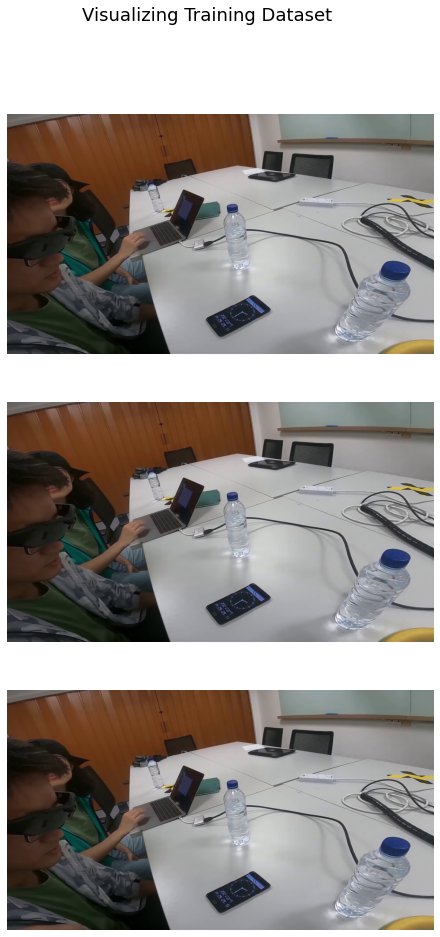

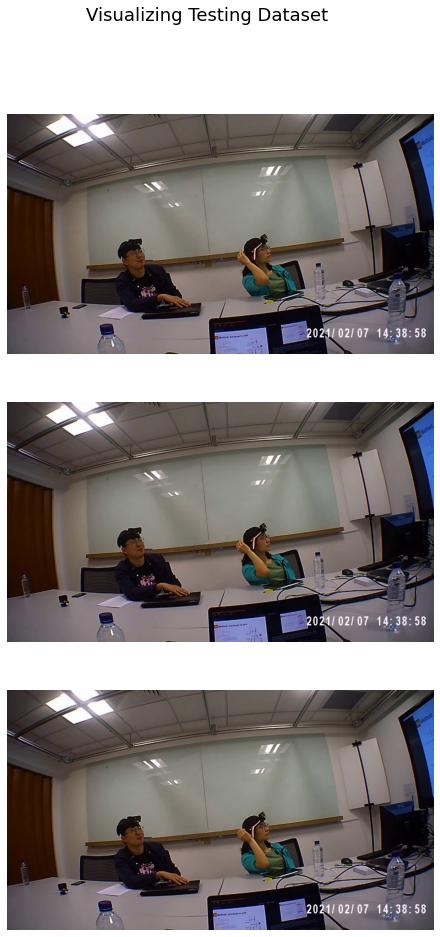

: 

: 

In [ ]:
# fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))

# # flatten the axis into a 1-d array to make it easier to access each axes
# axs = axs.flatten()

# # iterate through and enumerate the files, use i to index the axes
# for i in range(3):
#     sample = train_dataset[i]

#     # add the image to the axes
#     axs[i].imshow(sample['image'])
#     axs[i].axis('off')

# # add a figure title
# fig.suptitle('Visualizing Training Dataset', fontsize=18)

# fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))

# # flatten the axis into a 1-d array to make it easier to access each axes
# axs = axs.flatten()

# # iterate through and enumerate the files, use i to index the axes
# for i in range(3):
#     sample = test_dataset[i]

#     # add the image to the axes
#     axs[i].imshow(sample['image'])
#     axs[i].axis('off')

# # add a figure title
# fig.suptitle('Visualizing Testing Dataset', fontsize=18)